In [1]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from paths import *
import numpy as np
import pandas as pd

## Load models

In [38]:
sample = "serum"

model_1_name = "GLM_shortChain_fattyAcid_without_outlier_sample_{}.joblib".format(sample)
model_2_name = "GLM_shortChain_fattyAcid_without_outlier_ms_treated_sample_{}.joblib".format(sample)
model_3_name = "GLM_shortChain_fattyAcid_without_outlier_ms_not_treated_sample_{}.joblib".format(sample)
model_4_name = "GLM_shortChain_fattyAcid_with_outlier_sample_{}.joblib".format(sample)
model_5_name = "GLM_shortChain_fattyAcid_with_outlier_ms_treated_sample_{}.joblib".format(sample)
model_6_name = "GLM_shortChain_fattyAcid_with_outlier_ms_not_treated_sample_{}.joblib".format(sample)

model_1 = joblib.load(os.path.join(OUTPUT_PATH, model_1_name))
model_2 = joblib.load(os.path.join(OUTPUT_PATH, model_2_name))
model_3 = joblib.load(os.path.join(OUTPUT_PATH, model_3_name))
model_4 = joblib.load(os.path.join(OUTPUT_PATH, model_4_name))
model_5 = joblib.load(os.path.join(OUTPUT_PATH, model_5_name))
model_6 = joblib.load(os.path.join(OUTPUT_PATH, model_6_name))

model_list = [model_1, model_2, model_3, model_4, model_5, model_6]
model_name_list = ["Without outlier", "Without outlier-MS treated", "Without outlier-MS not treated",
                  "With outlier", "With outlier-MStreated", "With outlier-MS not treated"]

## Write model results to an excel sheet

In [14]:
all_model_summary_list = []
for index, model in enumerate(model_list):
    model_summary_list = []
    for item in model:
        analyte_name = item["analyte"]
        try:            
            disease_coeff = item["model"].params["Disease_label"]
            disease_coeff_pvalue = item["model"].pvalues["Disease_label"]
            disease_coeff_CI = tuple(item["model"].conf_int().loc['Disease_label'])
            model_converged_flag = item["model"].converged
        except:
            disease_coeff = None
            disease_coeff_pvalue = None
            disease_coeff_CI = None
            model_converged_flag = None
        model_summary_list.append((analyte_name, disease_coeff, disease_coeff_pvalue, disease_coeff_CI, model_converged_flag))        
    all_model_summary_list.append(pd.DataFrame(model_summary_list, columns=["analyte_name", "disease_coeff", "pvalue", "CI", "model_converged_flag"]))

# Create ExcelWriter object
writer = pd.ExcelWriter(os.path.join(OUTPUT_PATH, 'GLM_result_targeted_compounds_{}_sample.xlsx'.format(sample)))

# Loop through each DataFrame and save to a separate sheet
for i, df in enumerate(all_model_summary_list):
    sheet_name = model_name_list[i]
    df.to_excel(writer, sheet_name=sheet_name, index=False)
    
# Save and close the ExcelWriter object
writer.save()
writer.close()


## Parsing model results for downstream analysis

In [39]:
disease_coeff = []
pval = []
pval_thresh = 0.05

for model in model_list:
    disease_coeff_model = []
    pval_model = []
    for item in model:
        if (item["model"].pvalues["Disease_label"] < pval_thresh) & (item["model"].converged==1):
            disease_coeff_model.append(item["model"].params["Disease_label"])
            pval_model.append(item["model"].pvalues["Disease_label"])
        else:
            disease_coeff_model.append(None)
            pval_model.append(None)
    disease_coeff.append(disease_coeff_model)
    pval.append(pval_model)
        
analyte_list = []
for item in model_1:
    analyte_list.append(item["analyte"])
    
disease_coeff = np.array(disease_coeff).transpose()
disease_coeff[disease_coeff == None] = np.nan
disease_coeff = np.where(disease_coeff == None, np.nan, disease_coeff).astype(float)
disease_coeff_df = pd.DataFrame(disease_coeff, index=analyte_list, columns=model_name_list)

pval = np.array(pval).transpose()
pval[pval == None] = np.nan
pval = np.where(pval == None, np.nan, pval).astype(float)

## Heat map of disease coeffients for analytes across models

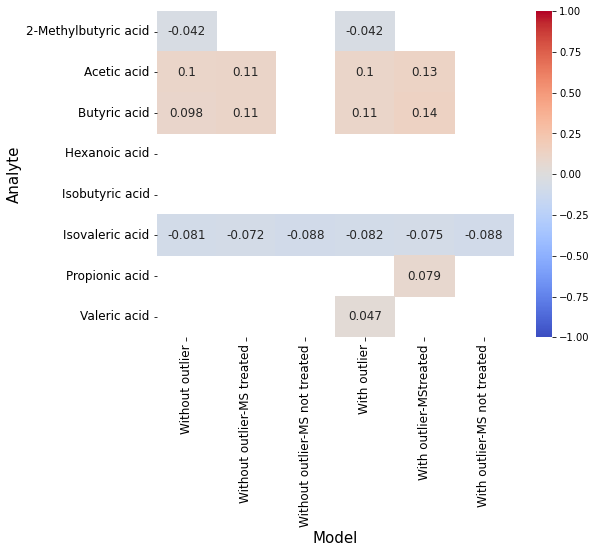

Saving the figure ...


In [42]:
FIG_SIZE = (8, 6)
FONTSIZE = 12
LABELSIZE = 15


indices = np.where(pval < 10**-5)
fig = plt.figure(figsize=FIG_SIZE)
ax = sns.heatmap(disease_coeff_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"fontsize": FONTSIZE})

# Add red outline to the boxes
for i, j in zip(indices[0], indices[1]):
    rect = plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3)
    ax.add_patch(rect)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=FONTSIZE)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=FONTSIZE)
plt.xlabel('Model', fontsize=LABELSIZE)
plt.ylabel('Analyte', fontsize=LABELSIZE)
plt.xlabel('Model')
plt.ylabel('Analyte')
plt.show()


print('Saving the figure ...')
fig_filename = os.path.join(OUTPUT_PATH, "figures", "heat_map_of_disease_coeff_vs_shortChain_fattyAcid_{}_sample_with_red_box_outline.svg".format(sample))
fig.savefig(fig_filename, format='svg', bbox_inches='tight')
